### Load image and label

In [1]:
import os
import numpy as np

path = '/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if ".avi" in file:
            files.append(os.path.join(r, file))
        
for f in files:
    print(f)
np.array(files).shape

/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/032/nightglasses/yawning.avi
/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/032/nightglasses/slowBlinkWithNodding.avi
/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/032/nightglasses/sleepyCombination.avi
/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/032/nightglasses/nonsleepyCombination.avi
/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/032/sunglasses/yawning.avi
/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/032/sunglasses/slowBlinkWithNodding.avi
/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/032/sunglasses/sleepyCombination.avi
/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/032/sunglasses/nonsleepyCombination.avi
/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/032/night_noglasses/yawning.avi
/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/032/night_noglasses/slowBlinkWit

(356,)

### MTCNN

In [2]:
from mtcnn.mtcnn import MTCNN
import cv2

img = cv2.imread("frame0.jpg")
detector = MTCNN()
print(detector.detect_faces(img))


InvalidImage: Image not valid.

### Crop image and Label

[HAAR Classifier](http://blog.topspeedsnail.com/archives/10511)
- haarcascade_frontalface_default(想法: 直接用這個切出臉部的框框)
- haarcascade_eye
- problem: 多個人臉的問題防範
- 用landmark下去+圈，否則會不夠精準

### <p style="color:red;">1. HAAR Classifier

In [2]:
import numpy as np
import cv2
import time



#==================Detector
face_haar = cv2.CascadeClassifier("./Tool/Detecter/haarcascade_frontalface_default.xml")
eye_haar = cv2.CascadeClassifier("./Tool/Detecter/haarcascade_eye.xml")
mouth_haar = cv2.CascadeClassifier("./Tool/Detecter/haarcascade_mcs_mouth.xml")
nose_haar = cv2.CascadeClassifier("./Tool/Detecter/haarcascade_mcs_nose.xml")
#==================

currentframe = 0
faceframe = 0


filename = '/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/001/glasses/yawning.avi'
#filename = '.\\Dataset\\Training_Evaluation_Dataset\\Training Dataset\\015\\sunglasses\\yawning.avi'
#filename = '.\\Dataset\\Training_Evaluation_Dataset\\Evaluation Dataset\\022\\022_nightnoglasses_mix.mp4'
cap = cv2.VideoCapture(filename)

while(cap.isOpened()):
    
    
    start_time = time.time()
    
    ret, frame = cap.read()
    if (not ret):
        break
    #print(type(frame))
    currentframe += 1
    
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #===========Detect global part and local part by haar
    faces = face_haar.detectMultiScale(gray_img, 1.3, 1)
#    faces = face_haar.detectMultiScale(gray_img,scaleFactor=1.15,minNeighbors=5,minSize=(5,5),flags = cv2.CASCADE_SCALE_IMAGE)
    flag = 0
    for face_x,face_y,face_w,face_h in faces:
        
        if(flag == 0):
            faceframe += 1 
            flag = 1
        
        cv2.rectangle(frame, (face_x, face_y), (face_x+face_w, face_y+face_h), (0,255,0), 2)
            # 眼长在脸上
        roi_gray_img = gray_img[face_y:face_y+face_h, face_x:face_x+face_w]
        roi_img = frame[face_y:face_y+face_h, face_x:face_x+face_w]

        eyes = eye_haar.detectMultiScale(roi_gray_img, 1.3, 5)
        for eye_x,eye_y,eye_w,eye_h in eyes:
            cv2.rectangle(roi_img, (eye_x,eye_y), (eye_x+eye_w, eye_y+eye_h), (255,0,0), 2)

        noses = nose_haar.detectMultiScale(roi_gray_img, 1.7, 5)
        for nose_x,nose_y,nose_w,nose_h in noses:
            cv2.rectangle(roi_img, (nose_x,nose_y), (nose_x+nose_w, nose_y+nose_h), (255,0,255), 2)

        mouthes = mouth_haar.detectMultiScale(roi_gray_img, 1.5, 7)
        for mouth_x,mouth_y,mouth_w,mouth_h in mouthes:
            cv2.rectangle(roi_img, (mouth_x,mouth_y), (mouth_x+mouth_w, mouth_y+mouth_h), (255,255,0), 2)
    
    if(currentframe%500==0):
        print(str(currentframe) + " " + str(faceframe))
            
    #if((time.time() - start_time) != 0):
    #    print("FPS: ", 1.0 / (time.time() - start_time))
                
    cv2.imshow('frame',frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break
print("Final:"+ str(currentframe) + " " + str(currentframe-faceframe))   
cap.release()
cv2.destroyAllWindows()

Final:279 4


### <p style="color:red;"> 2. Landmark

[Dlib vs Haar](https://hardliver.blogspot.com/2017/07/dlib-dlib.html)<br>
演算法是HOG加上Linear SVM
<p style="color:red;">加入FaceAligner


- [reference](https://github.com/italojs/facial-landmarks-recognition-)
- [find max value of the same index](https://stackoverflow.com/questions/39748916/find-maximum-value-and-index-in-a-python-list)<br>
解釋了為什麼要再用CNN，因為landmark無法偵測得很精準。<br>
1~27: 臉部輪廓<br>
28~36:鼻子<br>
37~42:左眼<br>43~48:右眼<br>
49~68:嘴巴<br>

![](https://i.imgur.com/f341aB4.jpg)

In [3]:
# import the necessary packages
from imutils import face_utils
import dlib
import cv2
import os 
import numpy as np
from operator import itemgetter
import time

DefaultPath = '.\\Dataset\\'

   
     
#==============================================================

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

filename = "/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/001/glasses/yawning.avi"
#filename = '.\\Dataset\\Training_Evaluation_Dataset\\Training Dataset\\001\\glasses\\yawning.avi'
#filename = '.\\Dataset\\Training_Evaluation_Dataset\\Training Dataset\\015\\sunglasses\\yawning.avi'
#filename = '.\\Dataset\\Training_Evaluation_Dataset\\Evaluation Dataset\\022\\022_nightnoglasses_mix.mp4'
print(filename)
cap = cv2.VideoCapture(filename)
#================================================================ create new folder
currentframe = 0
faceframe = 0

while(cap.isOpened()):
    
    start_time = time.time()
    
    # load the input image and convert it to grayscale
    ret, image = cap.read()
    
    if (not ret):
        break
    height,width = image.shape[:2]
    #image = cv2.resize(image,(width//2,height//2),interpolation=cv2.INTER_CUBIC)
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    currentframe += 1    
    # detect faces in the grayscale image
    rects = detector(gray, 0)
    
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        faceframe += 1
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        
        for (x, y) in shape:
            #count = count+1
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
            #if(count>=49 and count<=69):
                #cv2.putText(image,str(count), (x+2 , y+2 ), cv2.FONT_HERSHEY_COMPLEX,0.5, (0, 255, 255))

        
        #==================================================
        
        '''
        for (x, y) in shape:
            cv2.circle(image, (x, y), 2, (255, 0, 0), -1)
        '''    
    # show the output image with the face detections + facial landmarks
    if(currentframe%500==0):
        print(str(currentframe) + " " + str(faceframe))
    
    #print("FPS: ", 1.0 / (time.time() - start_time))
    
    cv2.imshow("Output", image)
    
    
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break
        
print("Final:"+ str(currentframe) + " " + str(currentframe-faceframe))     
cv2.destroyAllWindows()
cap.release()

/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/001/glasses/yawning.avi
500 500
1000 1000
Final:1118 0


In [4]:
# import the necessary packages
from imutils import face_utils
import dlib
import cv2
import numpy as np
from operator import itemgetter
import time
import os

DefaultPath = './Dataset/'

def CreateFolder(name):
    try:
        # creating a folder named data 
        if not os.path.exists(name):
            os.makedirs(name)
        # if not created then raise error 
    except OSError: 
        print ('Error: Creating directory of data')        
        
#==============================================================

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

filename = "/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/001/glasses/yawning.avi"

print(filename)
cap = cv2.VideoCapture(filename)

#================================================================ create new folder
CreateFolder(DefaultPath+"face")
CreateFolder(DefaultPath+"lefteye")
CreateFolder(DefaultPath+"righteye")
CreateFolder(DefaultPath+"nose")
CreateFolder(DefaultPath+"mouth")
#================================================================
Face_ImageDataList = []

currentframe = 0

while(cap.isOpened()):
    
    start_time = time.time()
    
    currentframe += 1
    # load the input image and convert it to grayscale
    ret, image = cap.read()
    height,width = image.shape[:2]
    image = cv2.resize(image,(width//2,height//2),interpolation=cv2.INTER_CUBIC)
    
    if (not ret):
        break
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    
        
    # detect faces in the grayscale image
    rects = detector(gray, 0)
    
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        #count = 0
        face_x = face_y = 0
        
        #face_y = face_y-1
        #face_x = face_x+1
        #print(str(face_x)+" "+str(face_y))
        
        
        for (x, y) in shape:
            #count = count+1
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
            #if():
            
            #if(count>=49 and count<=69):
                #cv2.putText(image,str(count), (x+2 , y+2 ), cv2.FONT_HERSHEY_COMPLEX,0.5, (0, 255, 255))
        
        
        #print(shape[0:3][0])
        #print(shape[1:10])
        #index, value = max(shape[1:10], key=lambda item: item[1])
       
        #max_value = max(shape[1:10], key=itemgetter(1))[0]
        #print(value)
        
        #print(max(shape[0:28], key=itemgetter(0))[0])#find max value of x 
        #print(max(shape[0:28], key=itemgetter(1))[1])#find max value of y 
        
        #==================================================Detect local part and global part
        face_max_x = max(shape[0:27], key=itemgetter(0))[0]+15
        face_min_x = min(shape[0:27], key=itemgetter(0))[0]-15
        face_max_y = max(shape[0:27], key=itemgetter(1))[1]+15
        face_min_y = min(shape[0:27], key=itemgetter(1))[1]-15
        face_image = image[face_min_y:face_max_y,face_min_x:face_max_x]
        #face_image = cv2.resize(face_image,(64,64),interpolation=cv2.INTER_AREA)
        #cv2.imwrite(DefaultPath + "face/frame" + str(currentframe) + '.jpg',face_image) 
        #Face_ImageDataList.append(face_image)
        cv2.rectangle(image,(face_min_x,face_min_y),(face_max_x,face_max_y),(0, 255, 255),2)
        
        
        
        nose_max_x = max(shape[27:36], key=itemgetter(0))[0]+15
        nose_min_x = min(shape[27:36], key=itemgetter(0))[0]-15
        nose_max_y = max(shape[27:36], key=itemgetter(1))[1]+10
        nose_min_y = min(shape[27:36], key=itemgetter(1))[1]
        nose_image = image[nose_min_y:nose_max_y,nose_min_x:nose_max_x]
        #cv2.imwrite(DefaultPath + "nose/frame" + str(currentframe) + '.jpg',nose_image)
        cv2.rectangle(image,(nose_min_x,nose_min_y),(nose_max_x,nose_max_y),(255, 255, 0),2)
        
        lefteye_max_x = max(shape[36:42], key=itemgetter(0))[0]+15
        lefteye_min_x = min(shape[36:42], key=itemgetter(0))[0]-15
        lefteye_max_y = max(shape[36:42], key=itemgetter(1))[1]+15
        lefteye_min_y = min(shape[36:42], key=itemgetter(1))[1]-15
        lefteye_image = image[lefteye_min_y:lefteye_max_y,lefteye_min_x:lefteye_max_x]
        #cv2.imwrite(DefaultPath + "lefteye/frame" + str(currentframe) + '.jpg',lefteye_image)
        cv2.rectangle(image,(lefteye_min_x,lefteye_min_y),(lefteye_max_x,lefteye_max_y),(255, 0, 0),2)
        
        righteye_max_x = max(shape[42:48], key=itemgetter(0))[0]+15
        righteye_min_x = min(shape[42:48], key=itemgetter(0))[0]-15
        righteye_max_y = max(shape[42:48], key=itemgetter(1))[1]+15
        righteye_min_y = min(shape[42:48], key=itemgetter(1))[1]-15
        righteye_image = image[righteye_min_y:righteye_max_y,righteye_min_x:righteye_max_x]
        #cv2.imwrite(DefaultPath + "righteye/frame" + str(currentframe) + '.jpg',righteye_image)
        cv2.rectangle(image,(righteye_min_x,righteye_min_y),(righteye_max_x,righteye_max_y),(255, 255, 255),2)
        
        mouth_max_x = max(shape[48:], key=itemgetter(0))[0]+15
        mouth_min_x = min(shape[48:], key=itemgetter(0))[0]-15
        mouth_max_y = max(shape[48:], key=itemgetter(1))[1]+15
        mouth_min_y = min(shape[48:], key=itemgetter(1))[1]-15
        mouth_image = image[mouth_min_y:mouth_max_y,mouth_min_x:mouth_max_x]
        #cv2.imwrite(DefaultPath + "mouth/frame" + str(currentframe) + '.jpg',mouth_image)
        cv2.rectangle(image,(mouth_min_x,mouth_min_y),(mouth_max_x,mouth_max_y),(255, 0, 255),2)
        
        #if(currentframe%100==0):
        #    print ('Creating frame' + str(currentframe)) 
        #==================================================
        
        
        for (x, y) in shape:
            cv2.circle(image, (x, y), 2, (255, 0, 0), -1)
            
    # show the output image with the face detections + facial landmarks
    
    cv2.imshow("Output", image)
    cv2.imshow("face_image", face_image)
    cv2.imshow("nose_image", nose_image)
    cv2.imshow("lefteye_image", lefteye_image)
    cv2.imshow("righteye_image", righteye_image)
    cv2.imshow("mouth_image", mouth_image)
    
    print("FPS: ", 1.0 / (time.time() - start_time))
    
    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break
    
cv2.destroyAllWindows()
cap.release()


/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/001/glasses/yawning.avi
FPS:  9.825118998538287
FPS:  67.56397493516326
FPS:  94.02160950459539
FPS:  85.12550738756292
FPS:  94.44078177069261
FPS:  63.371468286344545
FPS:  91.02024695644626
FPS:  84.72143333266003
FPS:  99.13268730796501
FPS:  96.34105108416024
FPS:  86.38075624021748
FPS:  98.10319502268794
FPS:  81.41592095813033
FPS:  94.82510399710617
FPS:  73.96448410249175
FPS:  91.23804137390964
FPS:  84.39922730199613
FPS:  84.03061265376448
FPS:  69.10005107168158
FPS:  94.59200288671884
FPS:  87.53999958257675
FPS:  83.68189617333705
FPS:  75.2287548875417
FPS:  79.89302653383874
FPS:  99.57277496854451
FPS:  92.24941166120483
FPS:  83.62850420704231
FPS:  88.53599020559801
FPS:  79.29640412901274
FPS:  80.2230935485722
FPS:  97.63504737074885
FPS:  93.13431775285889
FPS:  93.56646663840989
FPS:  62.8350736318557
FPS:  89.59699228846688
FPS:  75.58121598731394
FPS:  61.76086700435858
FPS:  88.1656401740483
FPS

FPS:  83.2847640038919
FPS:  97.56237352003907
FPS:  77.94365569018063
FPS:  90.72492483398585
FPS:  102.58784395254983
FPS:  87.90510122815107
FPS:  86.90876691324257
FPS:  79.93108968250944
FPS:  81.72844894777865
FPS:  100.89252381410564
FPS:  105.20477576000803
FPS:  102.4850706152568
FPS:  93.74631769517892
FPS:  99.91909855397003
FPS:  103.6014326293689
FPS:  84.70603441311899
FPS:  102.92012857949108
FPS:  85.65397810815226
FPS:  96.71202932970554
FPS:  92.51801036726592
FPS:  95.45091256656502
FPS:  95.08521683933712
FPS:  101.72942032500606
FPS:  89.44604623389917
FPS:  99.55623071445525
FPS:  88.57712451427606
FPS:  99.19833498888416
FPS:  87.85538635554346
FPS:  94.6475008462146
FPS:  80.70004232885674
FPS:  78.05098812758197
FPS:  66.58788042356602
FPS:  80.02564298252308
FPS:  69.16842296212009
FPS:  98.00233655778307
FPS:  97.94283579301326
FPS:  92.5445479016813
FPS:  75.00543633762518
FPS:  76.4937262912168
FPS:  102.37500610202588
FPS:  99.28051695978412
FPS:  86.33630

FPS:  90.84085593000087
FPS:  89.42316220365001
FPS:  87.89957457509902
FPS:  79.964615267292
FPS:  100.53943142048996
FPS:  97.22991330149752
FPS:  84.28559371420533
FPS:  86.32919625398786
FPS:  98.75456771520061
FPS:  84.13005716578077
FPS:  103.3563490303344
FPS:  98.97828959788559
FPS:  98.64308560677328
FPS:  97.02972679112591
FPS:  79.38044589121466
FPS:  91.42299141200576
FPS:  95.57053341536218
FPS:  96.04103315625572
FPS:  98.31475317612863
FPS:  95.14129522513326
FPS:  88.63327839060057
FPS:  104.16490339244027
FPS:  83.23683270490177
FPS:  93.31666184617438
FPS:  84.85340886101558
FPS:  77.97843385141667
FPS:  102.32755129424967
FPS:  88.88120364484001
FPS:  82.36399340193229
FPS:  101.48819202477739
FPS:  88.45756706596929
FPS:  92.6385723120417
FPS:  89.8368745716244
FPS:  74.31702044721642
FPS:  78.85364065349401
FPS:  77.0487719749435
FPS:  98.6106173884422
FPS:  97.61459690932787
FPS:  90.94327840416305
FPS:  98.10090047947608
FPS:  90.55451444362883
FPS:  96.036635068

FPS:  98.300928095997
FPS:  92.081317233809
FPS:  80.86496491092774
FPS:  97.42640124503495
FPS:  87.76897966016573
FPS:  93.34365958962033
FPS:  102.00155642023347
FPS:  81.26291316309529
FPS:  96.60288359666498
FPS:  86.86736807223924
FPS:  97.6259572190024
FPS:  91.34136196345739
FPS:  92.84774427768185
FPS:  87.38315381570449
FPS:  85.4898699604582
FPS:  100.47199731710823
FPS:  86.32919625398786
FPS:  86.64843201256042
FPS:  103.12256287955155
FPS:  97.0499328983294
FPS:  99.57041116703067
FPS:  77.3928222160716
FPS:  102.34502952515739
FPS:  95.96851618807916
FPS:  97.7078295711324
FPS:  81.00395913401186
FPS:  96.18860222451553
FPS:  100.00247961470602
FPS:  94.38552590125568
FPS:  70.68733989483619
FPS:  86.40566931729224
FPS:  97.79896005782638
FPS:  91.07756449231304
FPS:  91.44890439332825
FPS:  85.73101136456545
FPS:  87.58204217999582
FPS:  90.86250297870497
FPS:  84.25342493270661
FPS:  86.7775065171515
FPS:  94.15035129857011
FPS:  96.62959037921024
FPS:  98.687183830968

KeyboardInterrupt: 

### MTCNN 

In [5]:
from mtcnn.mtcnn import MTCNN
# import the necessary packages
from imutils import face_utils
import dlib
import cv2
import numpy as np
import os
from operator import itemgetter
import time


DefaultPath = './Dataset/'
detector = MTCNN()

def CreateFolder(name):
    try:
        # creating a folder named data 
        if not os.path.exists(name):
            os.makedirs(name)
        # if not created then raise error 
    except OSError: 
        print ('Error: Creating directory of data')        
        
#==============================================================

filename = "/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/001/glasses/yawning.avi"
#filename = '.\\Dataset\\Training_Evaluation_Dataset\\Training Dataset\\015\\sunglasses\\yawning.avi'
#filename = '.\\Dataset\\Training_Evaluation_Dataset\\Evaluation Dataset\\022\\022_nightnoglasses_mix.mp4'

print(filename)
cap = cv2.VideoCapture(filename)

# img = cv2.imread("me.jpg")
detector = MTCNN()

#================================================================ create new folder
CreateFolder(DefaultPath+"face")
CreateFolder(DefaultPath+"lefteye")
CreateFolder(DefaultPath+"righteye")
CreateFolder(DefaultPath+"nose")
CreateFolder(DefaultPath+"mouth")
#================================================================
Face_ImageDataList = []

currentframe = 0
faceframe = 0
while(cap.isOpened()):
    
    start_time = time.time()
    
    
    # load the input image and convert it to grayscale
    ret, image = cap.read()
    if (not ret):
        break
    currentframe += 1
    height,width = image.shape[:2]
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = cv2.resize(image,(width//2,height//2),interpolation=cv2.INTER_CUBIC)
    #print(image.shape[:2])
    faces = detector.detect_faces(image)
    #print(np.array(faces).shape[0])
    #print(currentframe)
    for face in faces:
        
        faceframe = faceframe + 1
        
        x,y,w,h = face['box']
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
        
        
        #cv2.rectangle(image, (face['keypoints']['left_eye'][0]-int(w*0.2), face['keypoints']['left_eye'][1]-int(h*0.2)),
        #              (face['keypoints']['right_eye'][0]+int(w*0.2), face['keypoints']['right_eye'][1]+int(h*0.2)),(0, 255, 0),2)
        
        #cv2.rectangle(image, (face['keypoints']['mouth_left'][0]-int(w*0.2), face['keypoints']['mouth_left'][1]-int(h*0.2)),
        #              (face['keypoints']['mouth_right'][0]+int(w*0.2), face['keypoints']['mouth_right'][1]+int(h*0.2)),(0, 255, 0),2)
        
        
        #cv2.rectangle(image, (face['keypoints']['left_eye'][0], face['keypoints']['left_eye'][1]), 2, (0, 255, 0), -1)
        
        
        cv2.circle(image, (face['keypoints']['left_eye'][0], face['keypoints']['left_eye'][1]), 2, (0, 255, 0), -1)
        cv2.circle(image, (face['keypoints']['right_eye'][0], face['keypoints']['right_eye'][1]), 2, (0, 255, 0), -1)
        cv2.circle(image, (face['keypoints']['nose'][0], face['keypoints']['nose'][1]), 2, (0, 255, 0), -1)
        cv2.circle(image, (face['keypoints']['mouth_left'][0], face['keypoints']['mouth_left'][1]), 2, (0, 255, 0), -1)
        cv2.circle(image, (face['keypoints']['mouth_right'][0], face['keypoints']['mouth_right'][1]), 2, (0, 255, 0), -1)
    
    
    if(currentframe%500==0):
        print(str(currentframe) + " " + str(faceframe))
        
    cv2.imshow('img',image)
    
    #print("FPS: ", 1.0 / (time.time() - start_time))
    
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break
    
print("Final:"+ str(currentframe) + " " + str(currentframe-faceframe))         
cap.release()
cv2.destroyAllWindows()

/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/001/glasses/yawning.avi
Final:84 0


### Load Label

In [1]:
import numpy as np
#注意開頭是數字的資料夾或檔案
labelfile = '.\Dataset\Training_Evaluation_Dataset\Training Dataset\\001\glasses\\001_yawning_drowsiness.txt'
LabelList = []

inputfile = open(labelfile, 'r').read()


LabelList = list(map(int, inputfile))
Labelarray = np.array(LabelList)
Labelarray.shape

(1850,)

### test

In [2]:
# Importing all necessary libraries 
import cv2 
import os 
  
# Read the video from specified path 
cam = cv2.VideoCapture("/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/001/glasses/yawning.avi") 
  
try: 
      
    # creating a folder named data 
    if not os.path.exists('data'): 
        os.makedirs('data') 
  
# if not created then raise error 
except OSError: 
    print ('Error: Creating directory of data') 
  
# frame 
currentframe = 0
  
while(True): 
      
    # reading from frame 
    ret,frame = cam.read() 
  
    if ret: 
        # if video is still left continue creating images 
        name = './data/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name) 
  
        # writing the extracted images 
        cv2.imwrite(name, frame) 
  
        # increasing counter so that it will 
        # show how many frames are created 
        currentframe += 1
    else: 
        break
  
# Release all space and windows once done 
cam.release() 
cv2.destroyAllWindows() 

Creating..../data/frame0.jpg
Creating..../data/frame1.jpg
Creating..../data/frame2.jpg
Creating..../data/frame3.jpg
Creating..../data/frame4.jpg
Creating..../data/frame5.jpg
Creating..../data/frame6.jpg
Creating..../data/frame7.jpg
Creating..../data/frame8.jpg
Creating..../data/frame9.jpg
Creating..../data/frame10.jpg
Creating..../data/frame11.jpg
Creating..../data/frame12.jpg
Creating..../data/frame13.jpg
Creating..../data/frame14.jpg
Creating..../data/frame15.jpg
Creating..../data/frame16.jpg
Creating..../data/frame17.jpg
Creating..../data/frame18.jpg
Creating..../data/frame19.jpg
Creating..../data/frame20.jpg
Creating..../data/frame21.jpg
Creating..../data/frame22.jpg
Creating..../data/frame23.jpg
Creating..../data/frame24.jpg
Creating..../data/frame25.jpg
Creating..../data/frame26.jpg
Creating..../data/frame27.jpg
Creating..../data/frame28.jpg
Creating..../data/frame29.jpg
Creating..../data/frame30.jpg
Creating..../data/frame31.jpg
Creating..../data/frame32.jpg
Creating..../data/fr

Creating..../data/frame320.jpg
Creating..../data/frame321.jpg
Creating..../data/frame322.jpg
Creating..../data/frame323.jpg
Creating..../data/frame324.jpg
Creating..../data/frame325.jpg
Creating..../data/frame326.jpg
Creating..../data/frame327.jpg
Creating..../data/frame328.jpg
Creating..../data/frame329.jpg
Creating..../data/frame330.jpg
Creating..../data/frame331.jpg
Creating..../data/frame332.jpg
Creating..../data/frame333.jpg
Creating..../data/frame334.jpg
Creating..../data/frame335.jpg
Creating..../data/frame336.jpg
Creating..../data/frame337.jpg
Creating..../data/frame338.jpg
Creating..../data/frame339.jpg
Creating..../data/frame340.jpg
Creating..../data/frame341.jpg
Creating..../data/frame342.jpg
Creating..../data/frame343.jpg
Creating..../data/frame344.jpg
Creating..../data/frame345.jpg
Creating..../data/frame346.jpg
Creating..../data/frame347.jpg
Creating..../data/frame348.jpg
Creating..../data/frame349.jpg
Creating..../data/frame350.jpg
Creating..../data/frame351.jpg
Creating

Creating..../data/frame631.jpg
Creating..../data/frame632.jpg
Creating..../data/frame633.jpg
Creating..../data/frame634.jpg
Creating..../data/frame635.jpg
Creating..../data/frame636.jpg
Creating..../data/frame637.jpg
Creating..../data/frame638.jpg
Creating..../data/frame639.jpg
Creating..../data/frame640.jpg
Creating..../data/frame641.jpg
Creating..../data/frame642.jpg
Creating..../data/frame643.jpg
Creating..../data/frame644.jpg
Creating..../data/frame645.jpg
Creating..../data/frame646.jpg
Creating..../data/frame647.jpg
Creating..../data/frame648.jpg
Creating..../data/frame649.jpg
Creating..../data/frame650.jpg
Creating..../data/frame651.jpg
Creating..../data/frame652.jpg
Creating..../data/frame653.jpg
Creating..../data/frame654.jpg
Creating..../data/frame655.jpg
Creating..../data/frame656.jpg
Creating..../data/frame657.jpg
Creating..../data/frame658.jpg
Creating..../data/frame659.jpg
Creating..../data/frame660.jpg
Creating..../data/frame661.jpg
Creating..../data/frame662.jpg
Creating

Creating..../data/frame929.jpg
Creating..../data/frame930.jpg
Creating..../data/frame931.jpg
Creating..../data/frame932.jpg
Creating..../data/frame933.jpg
Creating..../data/frame934.jpg
Creating..../data/frame935.jpg
Creating..../data/frame936.jpg
Creating..../data/frame937.jpg
Creating..../data/frame938.jpg
Creating..../data/frame939.jpg
Creating..../data/frame940.jpg
Creating..../data/frame941.jpg
Creating..../data/frame942.jpg
Creating..../data/frame943.jpg
Creating..../data/frame944.jpg
Creating..../data/frame945.jpg
Creating..../data/frame946.jpg
Creating..../data/frame947.jpg
Creating..../data/frame948.jpg
Creating..../data/frame949.jpg
Creating..../data/frame950.jpg
Creating..../data/frame951.jpg
Creating..../data/frame952.jpg
Creating..../data/frame953.jpg
Creating..../data/frame954.jpg
Creating..../data/frame955.jpg
Creating..../data/frame956.jpg
Creating..../data/frame957.jpg
Creating..../data/frame958.jpg
Creating..../data/frame959.jpg
Creating..../data/frame960.jpg
Creating

Creating..../data/frame1190.jpg
Creating..../data/frame1191.jpg
Creating..../data/frame1192.jpg
Creating..../data/frame1193.jpg
Creating..../data/frame1194.jpg
Creating..../data/frame1195.jpg
Creating..../data/frame1196.jpg
Creating..../data/frame1197.jpg
Creating..../data/frame1198.jpg
Creating..../data/frame1199.jpg
Creating..../data/frame1200.jpg
Creating..../data/frame1201.jpg
Creating..../data/frame1202.jpg
Creating..../data/frame1203.jpg
Creating..../data/frame1204.jpg
Creating..../data/frame1205.jpg
Creating..../data/frame1206.jpg
Creating..../data/frame1207.jpg
Creating..../data/frame1208.jpg
Creating..../data/frame1209.jpg
Creating..../data/frame1210.jpg
Creating..../data/frame1211.jpg
Creating..../data/frame1212.jpg
Creating..../data/frame1213.jpg
Creating..../data/frame1214.jpg
Creating..../data/frame1215.jpg
Creating..../data/frame1216.jpg
Creating..../data/frame1217.jpg
Creating..../data/frame1218.jpg
Creating..../data/frame1219.jpg
Creating..../data/frame1220.jpg
Creating

Creating..../data/frame1456.jpg
Creating..../data/frame1457.jpg
Creating..../data/frame1458.jpg
Creating..../data/frame1459.jpg
Creating..../data/frame1460.jpg
Creating..../data/frame1461.jpg
Creating..../data/frame1462.jpg
Creating..../data/frame1463.jpg
Creating..../data/frame1464.jpg
Creating..../data/frame1465.jpg
Creating..../data/frame1466.jpg
Creating..../data/frame1467.jpg
Creating..../data/frame1468.jpg
Creating..../data/frame1469.jpg
Creating..../data/frame1470.jpg
Creating..../data/frame1471.jpg
Creating..../data/frame1472.jpg
Creating..../data/frame1473.jpg
Creating..../data/frame1474.jpg
Creating..../data/frame1475.jpg
Creating..../data/frame1476.jpg
Creating..../data/frame1477.jpg
Creating..../data/frame1478.jpg
Creating..../data/frame1479.jpg
Creating..../data/frame1480.jpg
Creating..../data/frame1481.jpg
Creating..../data/frame1482.jpg
Creating..../data/frame1483.jpg
Creating..../data/frame1484.jpg
Creating..../data/frame1485.jpg
Creating..../data/frame1486.jpg
Creating

Creating..../data/frame1722.jpg
Creating..../data/frame1723.jpg
Creating..../data/frame1724.jpg
Creating..../data/frame1725.jpg
Creating..../data/frame1726.jpg
Creating..../data/frame1727.jpg
Creating..../data/frame1728.jpg
Creating..../data/frame1729.jpg
Creating..../data/frame1730.jpg
Creating..../data/frame1731.jpg
Creating..../data/frame1732.jpg
Creating..../data/frame1733.jpg
Creating..../data/frame1734.jpg
Creating..../data/frame1735.jpg
Creating..../data/frame1736.jpg
Creating..../data/frame1737.jpg
Creating..../data/frame1738.jpg
Creating..../data/frame1739.jpg
Creating..../data/frame1740.jpg
Creating..../data/frame1741.jpg
Creating..../data/frame1742.jpg
Creating..../data/frame1743.jpg
Creating..../data/frame1744.jpg
Creating..../data/frame1745.jpg
Creating..../data/frame1746.jpg
Creating..../data/frame1747.jpg
Creating..../data/frame1748.jpg
Creating..../data/frame1749.jpg
Creating..../data/frame1750.jpg
Creating..../data/frame1751.jpg
Creating..../data/frame1752.jpg
Creating

1. LSTM simple => know how to store data <br>
2. Determine how to fix size
3. Deal with the issue that cannot detect landmark => 抓上一個frame 附近的frame
4. CNN model <br>
5. 3 channels <br>

[LSTM](https://blog.csdn.net/u011311291/article/details/79292032)

### Execute here

In [12]:
import numpy as np
from keras.utils import to_categorical
#注意開頭是數字的資料夾或檔案
labelfile = "/home/raoblack/DDD/Training_Evaluation_Dataset/Training Dataset/001/glasses/001_yawning_drowsiness.txt"
LabelList = []

inputfile = open(labelfile, 'r').read()


LabelList = list(map(int, inputfile))
Labelarray = np.array(LabelList)

Labelarray = to_categorical(Labelarray)
print(Labelarray.shape)

(1850, 2)


In [6]:
import os

path = '.\\Dataset\\face\\'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if ".jpg" in file:
            files.append(os.path.join(r, file))
        
files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
'''
for f in files:
    print(f)
'''


'\nfor f in files:\n    print(f)\n'

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
Face_ImageDataList = []
for f in files:
    ImgGray = cv2.imread(f,0)
    ImgRGB = cv2.merge((ImgGray,ImgGray,ImgGray))# this line make gray image to RGB
    Face_ImageDataList.append(ImgRGB)   
    #print(f)

(1850, 64, 64, 3)

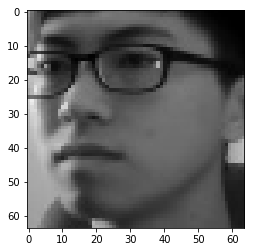

In [8]:
Face_ImageDataList
Facearray = np.array(Face_ImageDataList)

plt.imshow(Facearray[0], cmap='gray')
#Facearray.reshape(1850,4096)
#Facearray
Facearray.shape

### CNN LSTM
https://stackoverflow.com/questions/36992340/how-do-you-pass-video-features-from-a-cnn-to-an-lstm

problem: CNN的input一筆資料是一張圖片，LSTM則是一個影片。所以才要用multistage的方式。

先還是用圖片餵進去試試看
[VGG16](https://riptutorial.com/keras/example/32608/transfer-learning-using-keras-and-vgg)<br>
[Ref](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/)<br>
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]<br>
一個window裡面有許多timestamp，表示LSTM記憶要看幾個frame(幾個timestamp)

In [4]:
from keras.applications.vgg16 import VGG16
from keras import applications
from keras.layers import Input

img_width, img_height = 64, 64

vgg_model = applications.VGG16(weights='imagenet', include_top=False,input_shape = (64, 64, 3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [9]:
#在VGG16的block2_pool output再加layer，VGG16的3 4 5就不要了
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])
layer_dict

{'input_1': <tensorflow.python.keras.engine.input_layer.InputLayer at 0x7f00b02bcb38>,
 'block1_conv1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f004ca3c828>,
 'block1_conv2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f004ca3cef0>,
 'block1_pool': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x7f004ca40470>,
 'block2_conv1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f004dac9e80>,
 'block2_conv2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7eff5e7edd30>,
 'block2_pool': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x7eff5df8c7f0>,
 'block3_conv1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7eff5df930f0>,
 'block3_conv2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7eff5df9c438>,
 'block3_conv3': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7eff5c7235f8>,
 'block3_pool': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x7eff5c729518>,
 'block4_conv1':

In [10]:
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import concatenate
#Functional API



Conv2_out = layer_dict['block2_pool'].output

Conv3_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv2_out)
Conv3_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv3_out)
Conv3_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv3_out)
Conv3_Poolout = MaxPooling2D(pool_size=(2, 2))(Conv3_out)

Conv4_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv3_Poolout)
Conv4_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv4_out)
Conv4_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv4_out)
Conv4_Poolout = MaxPooling2D(pool_size=(2, 2))(Conv4_out)

Conv5_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv4_Poolout)
Conv5_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv5_out)
Conv5_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv5_out)
Conv5_Poolout = MaxPooling2D(pool_size=(2, 2))(Conv5_out)


FC6_1 = MaxPooling2D(pool_size=(16, 16))(Conv3_out)
FC6_2 = MaxPooling2D(pool_size=(8, 8))(Conv4_out)
FC6_3 = MaxPooling2D(pool_size=(4, 4))(Conv5_out)

FC6_in=concatenate([FC6_1,FC6_2,FC6_3])

out = Flatten()(FC6_in)
out = Dense(256, activation='relu',kernel_initializer='random_uniform')(out)
out = Dense(256, activation='relu',kernel_initializer='random_uniform')(out)
out = Dense(2, activation='softmax',kernel_initializer='random_uniform')(out)


In [6]:
from keras.models import Model
from keras import optimizers
custom_model = Model(input=vgg_model.input, output=out)

# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_model.layers[:7]:
    layer.trainable = False
    print(layer)


sgd = optimizers.SGD(lr=0.000005, decay=0.0005, momentum=0.9, nesterov=True)
# Do not forget to compile it
custom_model.compile(loss='categorical_crossentropy',
                     optimizer=sgd, 
                     metrics=['accuracy'])

custom_model.summary()


NameError: name 'vgg_model' is not defined

### Plot model

In [7]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils import plot_model

plot_model(custom_model, to_file='model.png')

NameError: name 'custom_model' is not defined

In [13]:
model_result = custom_model.fit(Facearray, Labelarray,
                        batch_size = 1,
                        epochs = 40,
                        verbose = 1)
model_result = custom_model.fit(Eyearray, Labelarray,
                        batch_size = 1,
                        epochs = 40,
                        verbose = 1)


Epoch 1/40
1850/1850 [==============================] - 28s 15ms/step - loss: 0.6119 - acc: 0.6681
Epoch 2/40
1850/1850 [==============================] - 18s 9ms/step - loss: 0.4529 - acc: 0.8005
Epoch 3/40
1850/1850 [==============================] - 18s 10ms/step - loss: 0.3798 - acc: 0.8427
Epoch 4/40
1850/1850 [==============================] - 18s 10ms/step - loss: 0.3382 - acc: 0.8762
Epoch 5/40
1850/1850 [==============================] - 18s 9ms/step - loss: 0.3053 - acc: 0.8865
Epoch 6/40
1850/1850 [==============================] - 18s 10ms/step - loss: 0.2857 - acc: 0.9016
Epoch 7/40
1850/1850 [==============================] - 18s 10ms/step - loss: 0.2701 - acc: 0.9124
Epoch 8/40
1850/1850 [==============================] - 18s 10ms/step - loss: 0.2533 - acc: 0.9216
Epoch 9/40
1850/1850 [==============================] - 18s 9ms/step - loss: 0.2415 - acc: 0.9335
Epoch 10/40
1850/1850 [==============================] - 18s 9ms/step - loss: 0.2306 - acc: 0.9368
Epoch 11/40
1

In [14]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.callbacks import TensorBoard

# define dataset
X = Facearray
y = Labelarray

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# 4 samples (X.shape[0])
timesteps = 50
print(X.shape)
X = X.reshape(int(X.shape[0]/timesteps), 1, timesteps, 4096)

print(X.shape)
X

(1850, 64, 64, 3)


ValueError: cannot reshape array of size 22732800 into shape (37,1,50,4096)

In [11]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 50, 4096)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

NameError: name 'Sequential' is not defined

In [86]:
# fit model
model.fit(X, y, epochs=500)
#model.fit(X, y, epochs=50,callbacks=[TensorBoard(log_dir='./log_dir')])

ValueError: Error when checking target: expected dense_15 to have shape (1,) but got array with shape (50,)

In [10]:
# demonstrate prediction
x_input = array([50, 60, 70, 80])
x_input = x_input.reshape((1, 2, 2, 1))
yhat = model.predict(x_input, verbose=0)

NameError: name 'array' is not defined

### New model

In [56]:
# Multiple Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend

eyes_width = 150
eyes_height = 70
mouth_width = 100
mouth_height = 75
face_width = 210
face_height = 250



# first input model: eyes
eyes1 = Input(shape=(eyes_width,eyes_height,1))
conv11 = Conv2D(32, kernel_size=(3, 3), activation='relu')(eyes1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
conv12 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
flat1 = Flatten()(pool12)


# second input model: mouth
mouth1 = Input(shape=(mouth_width,mouth_height,1))
conv21 = Conv2D(32, kernel_size=(3, 3), activation='relu')(mouth1)
pool21 = MaxPooling2D(pool_size=(2, 2))(conv21)
conv22 = Conv2D(16, kernel_size=(3, 3), activation='relu')(pool21)
pool22 = MaxPooling2D(pool_size=(2, 2))(conv22)
flat2 = Flatten()(pool22)


# input model: face
#==========================================================BlockA================================
face1 = Input(shape=(face_width,face_height,1))
conv311 = Conv2D(32, kernel_size=(1, 1), activation='relu',padding='same')(face1)
#conv311 = Flatten()(conv311)

conv321 = Conv2D(32, kernel_size=(1, 1), activation='relu',padding='same')(face1)
conv322 = Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same')(conv321)
#conv322 = Flatten()(conv322)

conv331 = Conv2D(32, kernel_size=(1, 1), activation='relu',padding='same')(face1)
conv332 = Conv2D(48, kernel_size=(3, 3), activation='relu',padding='same')(conv331)
conv333 = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(conv332)
#conv333 = Flatten()(conv333)

print(backend.int_shape(face1)[2])

conv333 = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(conv333)

#face1_flatten =  Flatten()(face1)
BlockA_out = concatenate([conv311, conv322, conv333])

model.add(Lambda(lambda x: BlockA_out+face1))





#==========================================================BlockB================================
conv411 = Conv2D(192, kernel_size=(1, 1), activation='relu',padding='same')(BlockA_out)
#conv411 = Flatten()(conv411)

conv421 = Conv2D(128, kernel_size=(1, 1), activation='relu',padding='same')(BlockA_out)
conv422 = Conv2D(160, kernel_size=(1, 7), activation='relu',padding='same')(conv421)
conv423 = Conv2D(160, kernel_size=(7, 1), activation='relu',padding='same')(conv422)
#conv423 = Flatten()(conv423)

BlockB_out = concatenate([conv411, conv423, BlockA_out])

flat3 = Flatten()(BlockB_out)

merge = concatenate([flat1, flat2,flat3])


model_inspection_resnet = Model(inputs=[eyes1, mouth1, face1], outputs=merge)

250


In [57]:
model_inspection_resnet.summary()


import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils import plot_model

plot_model(model_inspection_resnet, to_file='model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_153 (InputLayer)          (None, 210, 250, 1)  0                                            
__________________________________________________________________________________________________
conv2d_538 (Conv2D)             (None, 210, 250, 32) 64          input_153[0][0]                  
__________________________________________________________________________________________________
conv2d_539 (Conv2D)             (None, 210, 250, 48) 13872       conv2d_538[0][0]                 
__________________________________________________________________________________________________
conv2d_536 (Conv2D)             (None, 210, 250, 32) 64          input_153[0][0]                  
__________________________________________________________________________________________________
conv2d_540

### [InceptionResNet 2](https://medium.com/@mannasiladittya/building-inception-resnet-v2-in-keras-from-scratch-a3546c4d93f0)



In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations



def conv2d(x,numfilt,filtsz,strides=1,pad='same',act=True,name=None):
    x = Conv2D(numfilt,kernel_size = filtsz,strides = strides,padding=pad,data_format='channels_last',use_bias=False,name=name+'conv2d')(x)
    x = BatchNormalization(axis=3,scale=False,name=name+'conv2d'+'bn')(x)
    
    if act:
        x = Activation('relu',name=name+'conv2d'+'act')(x)
    
    return x

def incresA(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,32,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,32,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,32,3,1,pad,True,name=name+'b1_2')
    branch2 = conv2d(x,32,1,1,pad,True,name=name+'b2_1')
    branch2 = conv2d(branch2,48,3,1,pad,True,name=name+'b2_2')
    branch2 = conv2d(branch2,64,3,1,pad,True,name=name+'b2_3')
    branches = [branch0,branch1,branch2]
    mixed = Concatenate(axis=3, name=name + '_concat')(branches)
    filt_exp_1x1 = conv2d(mixed,384,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

def incresB(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,128,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,160,[1,7],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,192,[7,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,1152,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

In [35]:
eyes_width = 150
eyes_height = 70
mouth_width = 100
mouth_height = 75
face_width = 210
face_height = 250
num_classes = 2

# first input model: eyes
eyes1 = Input(shape=(eyes_width,eyes_height,1))
conv11 = Conv2D(32, kernel_size=(3, 3), activation='relu')(eyes1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
conv12 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool11)
#pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
#flat1 = Flatten()(pool12)
pool12 = GlobalAveragePooling2D(data_format='channels_last')(conv12)
flat1 = Flatten()(pool12)


# second input model: mouth
mouth1 = Input(shape=(mouth_width,mouth_height,1))
conv21 = Conv2D(32, kernel_size=(3, 3), activation='relu')(mouth1)
pool21 = MaxPooling2D(pool_size=(2, 2))(conv21)
conv22 = Conv2D(16, kernel_size=(3, 3), activation='relu')(pool21)
#pool22 = MaxPooling2D(pool_size=(2, 2))(conv22)
#flat2 = Flatten()(pool22)
pool22 = GlobalAveragePooling2D(data_format='channels_last')(conv22)
flat2 = Flatten()(pool22)

# input model: face
face1 = Input(shape=(face_width,face_height,1))

x = incresA(face1,0.15,name='incresA_1')

#35 × 35 to 17 × 17 reduction module.
x_red_11 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_1')(x)

x_red_12 = conv2d(x,384,3,2,'valid',True,name='x_red1_c1')

x_red_13 = conv2d(x,256,1,1,'same',True,name='x_red1_c2_1')
x_red_13 = conv2d(x_red_13,256,3,1,'same',True,name='x_red1_c2_2')
x_red_13 = conv2d(x_red_13,384,3,2,'valid',True,name='x_red1_c2_3')

x = Concatenate(axis=3, name='red_concat_1')([x_red_11,x_red_12,x_red_13])

x = incresB(x,0.1,name='incresB_1')

x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.6)(x)
flat3 = Flatten()(x)

merge = Concatenate(axis=1, name='concat_2')([flat1, flat2,flat3])
output = Dense(num_classes, activation='softmax')(merge)

In [36]:
model = Model(inputs=[eyes1, mouth1, face1], outputs=output, name='inception_resnet_v2')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           (None, 210, 250, 1)  0                                            
__________________________________________________________________________________________________
incresA_1b2_1conv2d (Conv2D)    (None, 210, 250, 32) 32          input_57[0][0]                   
__________________________________________________________________________________________________
incresA_1b2_1conv2dbn (BatchNor (None, 210, 250, 32) 96          incresA_1b2_1conv2d[0][0]        
__________________________________________________________________________________________________
incresA_1b2_1conv2dact (Activat (None, 210, 250, 32) 0           incresA_1b2_1conv2dbn[0][0]      
__________________________________________________________________________________________________
incresA_1b

In [30]:
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', 
                  show_shapes=True, show_layer_names=True)

### LSTM


In [2]:
import numpy as np
from keras.utils import to_categorical
#注意開頭是數字的資料夾或檔案
labelfile = '.\Dataset\Training_Evaluation_Dataset\Training Dataset\\001\glasses\\001_yawning_drowsiness.txt'
LabelList = []

inputfile = open(labelfile, 'r').read()


LabelList = list(map(int, inputfile))
Labelarray = np.array(LabelList)

Labelarray = to_categorical(Labelarray)
print(Labelarray.shape)
Labelarray[0]

(1850, 2)


array([1., 0.], dtype=float32)

In [2]:
import os

path = '.\\Dataset\\face\\'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if ".jpg" in file:
            files.append(os.path.join(r, file))
        
files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
'''
for f in files:    print(f)
'''


'\nfor f in files:    print(f)\n'

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
Face_ImageDataList = []
for f in files:
    ImgGray = cv2.imread(f,0)
    ImgRGB = cv2.merge((ImgGray,ImgGray,ImgGray))# this line make gray image to RGB
    Face_ImageDataList.append(ImgRGB)   
    #print(f)

(1850, 64, 64, 3)

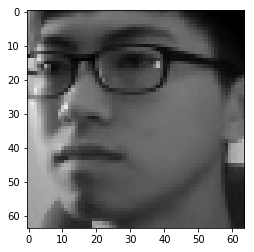

In [4]:
Face_ImageDataList
Facearray = np.array(Face_ImageDataList)

plt.imshow(Facearray[5], cmap='gray')
#Facearray.reshape(1850,4096)
#Facearray
Facearray.shape

In [5]:
Facearray_NEW = Facearray.reshape(1850,64*64*3)
Facearray_NEW.shape

(1850, 12288)

### Step1 Padding Zero to the original array

In [6]:
Facearray_Padding = Facearray_NEW
#Facearray_NEW[0]
ZeroArray = 0 * Facearray_NEW[0]#把某一個feature 乘上0(or 產生shape[1]個0)
print(ZeroArray.shape)
print(type(Facearray_NEW))
print(type(ZeroArray))

(12288,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
timestep = 50
PaddingList = np.array([ZeroArray for i in range(timestep-1)])
print(PaddingList.shape)
print(Facearray_NEW.shape)

PaddingList = np.concatenate((PaddingList,Facearray_NEW),axis=0)
print(PaddingList.shape)
PaddingList

(49, 12288)
(1850, 12288)
(1899, 12288)


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [142, 142, 142, ...,  27,  27,  27],
       [153, 153, 153, ...,  27,  27,  27],
       [154, 154, 154, ...,  29,  29,  29]], dtype=uint8)

### Step2 TimeSequence overlapping

In [13]:
frame_number = Facearray_NEW.shape[0]
FeatureList = []
TempList = []
for j in range(frame_number):
    TempList = []
    for i in range (timestep):#(Facearray_NEW.shape[0]):
        TempList.append(PaddingList[i+j])
    
    FeatureList.append(TempList)
    
LSTM_input_array = np.array(FeatureList)

In [14]:
LSTM_input_array.shape

(1850, 50, 12288)

### LSTM

In [47]:
# http://philipperemy.github.io/keras-stateful-lstm/
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(10, batch_input_shape=(50,LSTM_input_array.shape[1],LSTM_input_array.shape[2]), return_sequences=False, stateful=True))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (50, 10)                  491960    
_________________________________________________________________
dense_4 (Dense)              (50, 2)                   22        
Total params: 491,982
Trainable params: 491,982
Non-trainable params: 0
_________________________________________________________________


In [48]:
import numpy as np
from keras.utils import to_categorical
#注意開頭是數字的資料夾或檔案
labelfile = '.\Dataset\Training_Evaluation_Dataset\Training Dataset\\001\glasses\\001_yawning_drowsiness.txt'
LabelList = []

inputfile = open(labelfile, 'r').read()


LabelList = list(map(int, inputfile))
Labelarray = np.array(LabelList)

Labelarray = to_categorical(Labelarray)
print(Labelarray.shape)

(1850, 2)


In [50]:
model.fit(LSTM_input_array, Labelarray, epochs=100, batch_size=50)

Epoch 1/100
1850/1850 [==============================] - 18s 9ms/step - loss: 0.7237 - acc: 0.5414
Epoch 2/100
1850/1850 [==============================] - 12s 6ms/step - loss: 0.6952 - acc: 0.5443
Epoch 3/100
1600/1850 [========================>.....] - ETA: 1s - loss: 0.6925 - acc: 0.5450

KeyboardInterrupt: 

In [ ]:
num_samples = 235578
batch_size = 200


import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import cv2
from math import ceil

from keras.callbacks import EarlyStopping




def LoadImageandLabel(batch_size,AllVideoImageFolder,AllLabelFile):
    #print(Originalpath)
    count=0
    
    #while True:
    
    LabelFileindex = 0
    
    for Originalpath in AllVideoImageFolder:

        labelPath = AllLabelFile[LabelFileindex]
        LabelFileindex = LabelFileindex + 1

        Face_ImageDataList = []
        Eyes_ImageDataList = []
        Mouth_ImageDataList = []
        #=====load all label in a video
        LabelList = []
        TempLabelList = []
        inputfile = open(labelPath, 'r').read()
        TempLabelList = list(map(int, inputfile))

        #=========================

        TEMP_ImageDataList = []

        path = Originalpath+"\\face"


        #=====find all files in path=======    
        Facefiles = []
        Eyefiles = []
        Mouthfiles = []
        # r=root, d=directories, f = files
        for r, d, f in os.walk(path):
            for file in f:
                if ".jpg" in file:
                    temp = os.path.join(r, file)
                    Facefiles.append(temp)
                    Eyefiles.append(temp.replace("face", "eyes"))
                    Mouthfiles.append(temp.replace("face", "mouth"))


        Facefiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        Eyefiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        Mouthfiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

        for FileIndex in range(len(Facefiles)):
            #======================load label

            index = Facefiles[FileIndex].find('frame')
            framenumber =int(Facefiles[FileIndex][index+5:-4]) 

            #print(framenumber)

            #if(judgeflag == 0 and TempLabelList[framenumber-1] == 1):
            #    judgeflag = 1
                #print(framenumber-1)

            #Labelarray = np.array(LabelList)

            Labelarray = to_categorical(TempLabelList[framenumber-1], num_classes=2)
            LabelList.append(Labelarray)
            #print(LabelList)


                #Labelarray = np.array(LabelList)
                #Labelarray = to_categorical(Labelarray, num_classes=2)

            #================================
            ImgGray = cv2.imread(Facefiles[FileIndex],0)
            #ImgRGB = cv2.merge((ImgGray,ImgGray,ImgGray))# this line make gray image to RGB
            #TEMP_ImageDataList.append(ImgRGB)  
            ImgGray = ImgGray.reshape(ImgGray.shape[0],ImgGray.shape[1],1)
            #print(ImgGray.shape)
            Face_ImageDataList.append(ImgGray)
            #print(np.array(Face_ImageDataList).shape)

            ImgGray = cv2.imread(Mouthfiles[FileIndex],0)
            ImgGray = ImgGray.reshape(ImgGray.shape[0],ImgGray.shape[1],1)
            Mouth_ImageDataList.append(ImgGray)


            ImgGray = cv2.imread(Eyefiles[FileIndex],0)
            ImgGray = ImgGray.reshape(ImgGray.shape[0],ImgGray.shape[1],1)
            Eyes_ImageDataList.append(ImgGray)
             #====================================

            count = count +1
            if count>=batch_size:

                    yield ([np.array(Eyes_ImageDataList),np.array(Mouth_ImageDataList),np.array(Face_ImageDataList)],np.array(LabelList))
                    count=0
                    Face_ImageDataList = []
                    Eyes_ImageDataList = []
                    Mouth_ImageDataList = []
                    LabelList = []
               